# Setup and settings

Import packages


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from copy import deepcopy
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# from pytorch_forecasting.metrics.quantile import QuantileLoss
from torchvision import models
from torchsummary import summary

Settings and hyperparameters.

In [78]:
LOC_DF_CRIMES:str = "df_crimes.csv" # Where to find the csv file
ONLY_BARNET: bool = True
VERBOSE: bool = True
verbose = True

PREDICT_MONTHS:int = 24              # How many months to predict forward in time (Test set)
TIME_SHIFT:int = 12                  # How many months to look back
LEARN_RATE:float = 0.0001         # How fast to learn
NUM_EPOCHS: int = 50_000           # How many epochs to train
BATCH_SIZE:int = 148
HIDDEN_SIZE:int = 15                #
PATIENCE:int = 5_000                 # How many epochs the model will accept the loss to not improve
# PATIENCE:int = 300                 # How many epochs the model will accept the loss to not improve
DROPOUT_PROB:float = 0.3
HUBER_DELTA:float = 0.8

In [79]:
if VERBOSE:
    torch.set_printoptions(threshold=10_000_0)
    torch.set_printoptions(linewidth=200)
    pd.options.display.max_rows = 999

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Data

In [80]:
WARDS_BARNET:list = ["High Barnet", "Underhill", "Barnet Vale", "East Barnet", "Friern Barnet","Woodhouse", 
                "Whetstone", "Brunswick Park", "Totteridge and Woodside", "Mill Hill", "Cricklewood",
                "Edgwarebury", "Burnt Oak", "Edgware", "Colindale South", "West Hendon", "Colindale North","Hendon",
                "West Finchley", "East Finchley", "Garden Suburb", "Finchley Church End", "Golders Green", "Childs Hill"]
# FEATURES:list = ["wards", "Month", "Burglary", "Public disorder and weapons", "Other theft", "Public order", "Robbery", "Violent crime", "Vehicle crime", "Other crime", "Anti-social behaviour"]

FEATURES:list = ["wards", "Month", "Burglary"]

# Data preparation (Data Frame)

In [81]:
def load_data(loc:str, li_features:list, li_barnet_wards:list) -> pd.DataFrame:
    # Reads data
    df_crimes = pd.read_csv(loc, index_col=0)
    # Set to correct datetime:
    df_crimes['Month'] = pd.to_datetime(df_crimes['Month'])
    df_crimes['Month'] = df_crimes['Month'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
    # Filter out the features of the crime dataset that you want
    df_crimes = df_crimes[li_features]

    # Filter out which wards to use:
    if ONLY_BARNET:
        df: pd.DataFrame = deepcopy(df_crimes[df_crimes["wards"].isin(li_barnet_wards)])
    else:
        df: pd.DataFrame = deepcopy(df_crimes)    
    return df

In [82]:
def make_multi_index(df:pd.DataFrame):
    # Change indexes, then sort
    df.set_index(['wards', 'Month'], inplace=True)
    df.sort_index(inplace=True)
    df.sort_values(by=['wards', 'Month'], inplace=True)

    # Get unique 'wards' and 'Month' from original DataFrame
    unique_wards = df.index.get_level_values('wards').unique()
    unique_Months = df.index.get_level_values('Month').unique()
    # Ensure 'wards' and 'Month' are of the same data type in new MultiIndex and original DataFrame's index
    new_index = pd.MultiIndex.from_product([unique_wards.astype(df.index.get_level_values('wards').dtype),
                                            unique_Months.astype(df.index.get_level_values('Month').dtype)],
                                        names=['wards', 'Month'])
    # Reindex DataFrame with new index and fill missing values with zeros
    df = df.reindex(new_index, fill_value=0)
    # Sort first by month, then by ward
    df.sort_index(level=["Month", "wards"], ascending=[True, True], inplace=True)
    return df



In [83]:
def shift_data_single_ward(df:pd.DataFrame, shift_back_months:int):
    "Shifts the data as to include the previous n months for a single variable "
    #! Choose which features to shift
    for i in range(shift_back_months):
        actual_shift = i + 1
        df[f"Burglary-t-{actual_shift}"] = df["Burglary"].shift(actual_shift).fillna(method='bfill')
    return df

In [84]:
def shift_all_wards(df:pd.DataFrame, shift_back_months:int, ward_count:int):
    full_df = pd.DataFrame()
    
    for i in range(ward_count):
        ward_name = df.index.get_level_values("wards")[i]
        tmp_df = deepcopy(df[df.index.isin([ward_name], level=0)])
        tmp_df2 = shift_data_single_ward(df=tmp_df, shift_back_months=shift_back_months)
        full_df = pd.concat([full_df, tmp_df2])
    
    # Sort back in the month, wards format.
    full_df.sort_index(level=["Month", "wards"], ascending=[True, True], inplace=True)   
    return full_df

In [85]:
def target_feature_split(df:pd.DataFrame):
    #! Filter for barnet
    df_target = deepcopy(df[["Burglary"]])
    df_features = deepcopy(df.drop(columns=["Burglary"], inplace=False)) 
    df_features = df_features.iloc[:, ::-1]
    return df_target, df_features

In [86]:
def df_statistics(df_target:pd.DataFrame, df_features:pd.DataFrame)-> None:
    # Just prints some statistics about these two dataframes
    print(f'Standard deviation in target data = {df_target["Burglary"].std()} ')
    # Some statistics
    num_wards = df_features.index.get_level_values('wards').nunique() # Number of unique 'wards'
    num_months = df_features.index.get_level_values('Month').nunique() # Number of unique 'Month'
    num_features = df_features.shape[1] # Number of features to train on

    return num_months, num_wards, num_features

In [87]:
df = load_data(loc=LOC_DF_CRIMES, li_features=FEATURES, li_barnet_wards=WARDS_BARNET)

values_barnet_vale  = df.loc[df['wards'] == "Barnet Vale"].Burglary.values # For validation later
# Make dataframe multi-indexed
df = make_multi_index(df=df)
# Shift the temporal data
df = shift_all_wards(df = df, shift_back_months=TIME_SHIFT, ward_count = df.index.get_level_values('wards').nunique())
# Split into features and target
df_target, df_features = target_feature_split(df=df)
# Print and return some info about these 2 dataframes
num_months, num_nodes, num_features = df_statistics(df_target=df_target, df_features=df_features)

Standard deviation in target data = 7.5198656676552895 


In [88]:
df_features.head()

,,Burglary-t-12,Burglary-t-11,Burglary-t-10,Burglary-t-9,Burglary-t-8,Burglary-t-7,Burglary-t-6,Burglary-t-5,Burglary-t-4,Burglary-t-3,Burglary-t-2,Burglary-t-1
wards,Month,,,,,,,,,,,,
Barnet Vale,2010-12,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
Brunswick Park,2010-12,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0
Burnt Oak,2010-12,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
Childs Hill,2010-12,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
Colindale North,2010-12,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0


In [89]:
df_target.head()

,,Burglary
wards,Month,
Barnet Vale,2010-12,13
Brunswick Park,2010-12,11
Burnt Oak,2010-12,10
Childs Hill,2010-12,19
Colindale North,2010-12,9


In [90]:
num_nodes, num_months, num_features

(24, 148, 12)

# Scaling data and making tensors

In [91]:
mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(df_features.values)
y_mm = mm.fit_transform(df_target.values)

df_features_scaled = pd.DataFrame(x_ss, columns=df_features.columns)
df_target_scaled = pd.DataFrame(y_mm, columns=df_target.columns)

# Convert DataFrames to tensor
t_x = torch.tensor(df_features_scaled.values, dtype=torch.float)
t_y = torch.tensor(df_target_scaled.values, dtype=torch.float)

# Reshape in the (month,1,features) and (month, ward) format
t_x = t_x.reshape(num_months, 1, num_nodes*num_features)
t_y= t_y.view(num_months, num_nodes)
print(f"x: {t_x.shape} y: {t_y.shape} \n\n")
cutoff = int(num_months-PREDICT_MONTHS)

t_x_train, t_x_test = torch.split(t_x, [cutoff, PREDICT_MONTHS])
t_y_train, t_y_test = torch.split(t_y, [cutoff, PREDICT_MONTHS ])


print(f"Train shape x: {t_x_train.shape}, Train shape y: {t_y_train.shape}")
print(f"Test shape x: {t_x_test.shape}, Test shape y: {t_y_test.shape}")

x: torch.Size([148, 1, 288]) y: torch.Size([148, 24]) 


Train shape x: torch.Size([124, 1, 288]), Train shape y: torch.Size([124, 24])
Test shape x: torch.Size([24, 1, 288]), Test shape y: torch.Size([24, 24])


# Make Pytorch DataSet and DataLoader

In [92]:
class CrimeSeriesDataSet(Dataset):
    def __init__(self, X, y) -> None:      
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def summary(self):
        pass

In [93]:
dataset_train = CrimeSeriesDataSet(t_x_train, t_y_train)
dataset_test = CrimeSeriesDataSet(t_x_test, t_y_test)

In [94]:
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [95]:
for _, batch, in enumerate(loader_train):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print("batch:", _, x_batch.shape, y_batch.shape)

batch: 0 torch.Size([124, 1, 288]) torch.Size([124, 24])


In [96]:
for _, batch, in enumerate(loader_test):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print("batch:", _, x_batch.shape, y_batch.shape)

batch: 0 torch.Size([24, 1, 288]) torch.Size([24, 24])


In [97]:
len(loader_train)

1

# Model definition

In [98]:
class LSTM(nn.Module):
    def __init__(self, seq_length, input_size, num_classes=1, hidden_size=2, num_layers=1):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT_PROB)

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.dropout(hn) #Apply dropout after the first fully connected (dense) layer
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [99]:
def train_one_epoch(model, optimiser, loss_fn, dataloader, device):
    model.train(True)
    running_loss = 0

    for i, batch in enumerate(dataloader):
        X_train, y_train = batch[0].to(device), batch[1].to(device)

        # print(X_train.shape, y_train.shape)
        outputs = model.forward(X_train) # forward pass
        # print(outputs.shape)
        loss = loss_fn(outputs, y_train)
        running_loss += loss.item()
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
    

    epoch_loss = running_loss / len(dataloader)
    
    return epoch_loss


In [100]:
def test_one_epoch(model, loss_fn, dataloader, device):
    model.train(False)
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            X_test, y_test = batch[0].to(device), batch[1].to(device)
            output=model(X_test)
            loss = loss_fn(output, y_test)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    
    return epoch_loss

# Training (main)

In [101]:
t_x_train.shape

torch.Size([124, 1, 288])

In [102]:
t_y_train.shape

torch.Size([124, 24])

In [103]:
X_tr, y_tr, X_te, y_te = t_x_train, t_y_train, t_x_test, t_y_test
model = LSTM(seq_length = X_tr.shape[1], input_size=X_tr.shape[2], num_classes=24, hidden_size=HIDDEN_SIZE).to(device)


# criterion = torch.nn.MSELoss()    # mean-squared error for regression
# criterion = torch.nn.L1Loss()
criterion = torch.nn.HuberLoss(reduction="mean", delta= HUBER_DELTA )


optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=0.01)
# optimizer = torch.optim.Adadelta(model.parameters())

train_loss_history = np.zeros(NUM_EPOCHS)
test_loss_history = np.zeros(NUM_EPOCHS)

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model=model, dataloader=loader_train, optimiser=optimizer, loss_fn=criterion, device=device)
    test_loss = test_one_epoch(model=model, loss_fn=criterion, dataloader=loader_test, device=device)
    train_loss_history[epoch] = train_loss
    test_loss_history[epoch] = test_loss

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}")
        
        if epoch > PATIENCE:
            train_loss_patience = train_loss_history[epoch-PATIENCE]
            test_loss_patience = test_loss_history[epoch-PATIENCE]
            
            test_improved = test_loss_patience - test_loss > 0
            train_improved = train_loss_patience - train_loss > 0
            
            if test_improved and train_improved:
                pass
            else:
                print("Breaking off training, ran out of patience")
                train_loss_history = deepcopy(train_loss_history[0:epoch])
                test_loss_history = deepcopy(test_loss_history[0:epoch])
                break

Epoch: 0, train loss: 0.02604738064110279, test loss: 0.014239566400647163
Epoch: 100, train loss: 0.011747574433684349, test loss: 0.005565942265093327
Epoch: 200, train loss: 0.006851202808320522, test loss: 0.003182120155543089
Epoch: 300, train loss: 0.005070887040346861, test loss: 0.0024950478691607714
Epoch: 400, train loss: 0.00435895100235939, test loss: 0.0022458352614194155
Epoch: 500, train loss: 0.003992386162281036, test loss: 0.0021246825344860554
Epoch: 600, train loss: 0.0037928675301373005, test loss: 0.0020368965342640877
Epoch: 700, train loss: 0.00370966037735343, test loss: 0.001994322519749403
Epoch: 800, train loss: 0.003661509370431304, test loss: 0.001974845537915826
Epoch: 900, train loss: 0.003608598606660962, test loss: 0.0019642089027911425
Epoch: 1000, train loss: 0.003542928257957101, test loss: 0.0019484508084133267
Epoch: 1100, train loss: 0.0035116032231599092, test loss: 0.0019375187112018466
Epoch: 1200, train loss: 0.003505938220769167, test loss: 

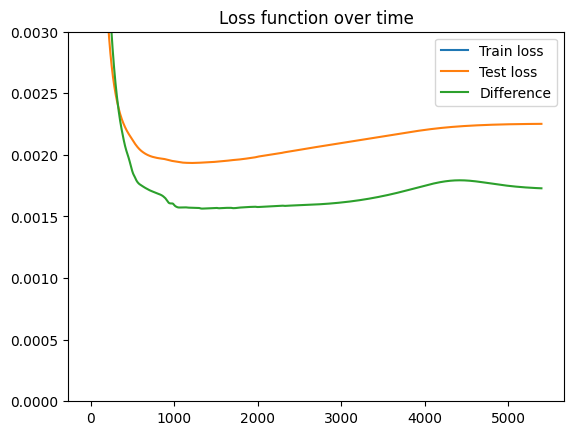

,train,test,difference
0,0.026047,0.014240,0.011808
1,0.025820,0.014088,0.011732
2,0.025594,0.013938,0.011656
3,0.025369,0.013790,0.011580
4,0.025147,0.013643,0.011504


In [104]:
df_losses = pd.DataFrame()
df_losses["train"] = train_loss_history
df_losses["test"] = test_loss_history
df_losses["difference"] = df_losses["train"] - df_losses["test"]

plt.plot(df_losses["train"], label="Train loss")
plt.plot(df_losses["test"], label="Test loss")
plt.plot(df_losses["difference"], label="Difference")
plt.xlabel = "Epoch number"
plt.ylabel = "loss"
plt.ylim(0, 0.003)
plt.title("Loss function over time")
plt.legend()
plt.show()

df_losses.head()

In [105]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [106]:
print(count_parameters(model))

23444


# Prediction 1

In [107]:
X_tr.shape

torch.Size([124, 1, 288])

In [108]:
with torch.no_grad():
    predicted_train = model(X_tr.to(device)).to("cpu").numpy() # Predicted values for the first training months
    predicted_train = mm.inverse_transform(predicted_train)
    print(predicted_train.shape)
    predicted_train = np.reshape(predicted_train, (predicted_train.shape[1], predicted_train.shape[0]))

    predicted_test = model(X_te.to(device)).to("cpu").numpy()
    predicted_test = mm.inverse_transform(predicted_test)
    predicted_test = np.reshape(predicted_test, (predicted_test.shape[1], predicted_test.shape[0]))

    tot_array = np.hstack((predicted_train, predicted_test))
    tot_array.shape

(124, 24)


In [109]:
actual_tr = y_tr.to("cpu").numpy()
actual_tr = mm.inverse_transform(actual_tr)
actual_tr = np.reshape(actual_tr, (actual_tr.shape[1], actual_tr.shape[0]))
actual_te = y_te.to("cpu").numpy()
actual_te = mm.inverse_transform(actual_te)
actual_te = np.reshape(actual_te, (actual_te.shape[1], actual_te.shape[0]))
actual_combined = np.hstack((actual_tr, actual_te))

# Visualization

Single ward

In [110]:
actual_combined.shape

(24, 148)

In [111]:
actual_combined[0]

array([13., 11., 10., 19.,  9.,  4., 11., 18., 17., 36., 17., 21., 19.,
       12., 13., 34., 15., 29.,  7.,  7., 27., 15.,  9., 11., 22., 14.,
       14., 39.,  6.,  5., 14., 21., 19., 29., 17., 22., 29., 32., 22.,
       30., 21., 32., 19., 16., 28., 18., 12., 22., 22., 21.,  9., 22.,
        9.,  4., 21., 12., 13., 29., 13., 26., 28., 19., 18., 27., 13.,
       19., 13.,  5., 20., 18., 18., 18., 15., 13.,  5., 32., 10.,  5.,
       24., 14., 14., 16.,  9., 25., 22., 23., 25., 41., 17., 25., 10.,
       22., 21., 10., 18.,  5., 25., 14., 12., 31.,  8.,  1., 32., 16.,
        7., 29.,  5., 18., 19., 19., 21., 33., 20., 15., 21., 16., 23.,
       15., 16., 12., 24., 29., 18., 41., 10.,  7., 16.,  9., 11.,  9.,
        4.,  6., 10., 10.,  6.,  4.,  9.,  7.,  9., 26.,  8.,  8.,  7.,
        4., 10.,  9.,  5.,  2.], dtype=float32)

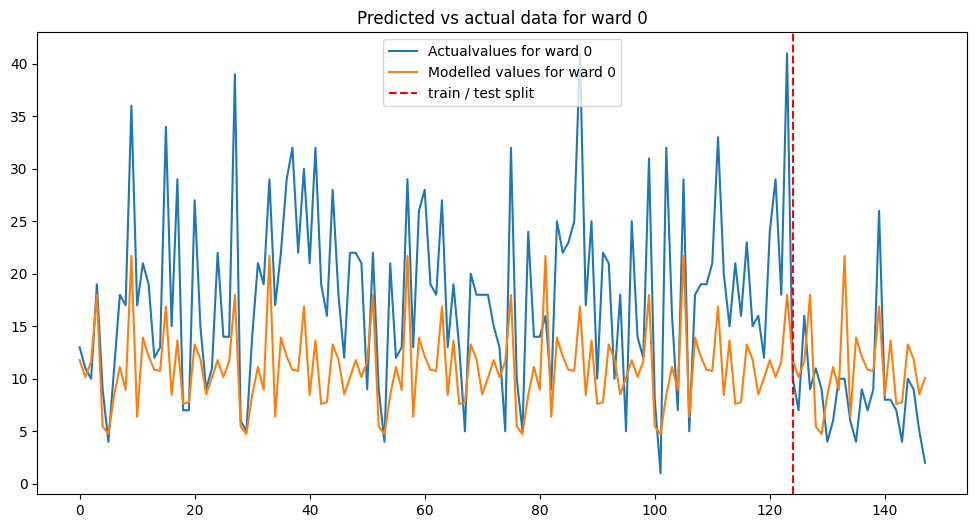

In [112]:
plt.figure(figsize=(12,6))
# combined_predictions = predicted_train + predicted_test
# combined_actual = np.concatenate(actual_tr, actual_te, axis=1)
pick_a_ward = 0 # Number between 0 and 23

plt.plot(actual_combined[pick_a_ward], label=f"Actualvalues for ward {pick_a_ward}")
plt.plot(tot_array[pick_a_ward], label=f"Modelled values for ward {pick_a_ward}")
plt.axvline(x=actual_tr.shape[1], c='r', linestyle='--', label='train / test split')  #size of the training set
plt.title(f"Predicted vs actual data for ward {pick_a_ward}")
plt.legend()
plt.show()

All wards

In [113]:
print(actual_combined[0])

[13. 11. 10. 19.  9.  4. 11. 18. 17. 36. 17. 21. 19. 12. 13. 34. 15. 29.
  7.  7. 27. 15.  9. 11. 22. 14. 14. 39.  6.  5. 14. 21. 19. 29. 17. 22.
 29. 32. 22. 30. 21. 32. 19. 16. 28. 18. 12. 22. 22. 21.  9. 22.  9.  4.
 21. 12. 13. 29. 13. 26. 28. 19. 18. 27. 13. 19. 13.  5. 20. 18. 18. 18.
 15. 13.  5. 32. 10.  5. 24. 14. 14. 16.  9. 25. 22. 23. 25. 41. 17. 25.
 10. 22. 21. 10. 18.  5. 25. 14. 12. 31.  8.  1. 32. 16.  7. 29.  5. 18.
 19. 19. 21. 33. 20. 15. 21. 16. 23. 15. 16. 12. 24. 29. 18. 41. 10.  7.
 16.  9. 11.  9.  4.  6. 10. 10.  6.  4.  9.  7.  9. 26.  8.  8.  7.  4.
 10.  9.  5.  2.]


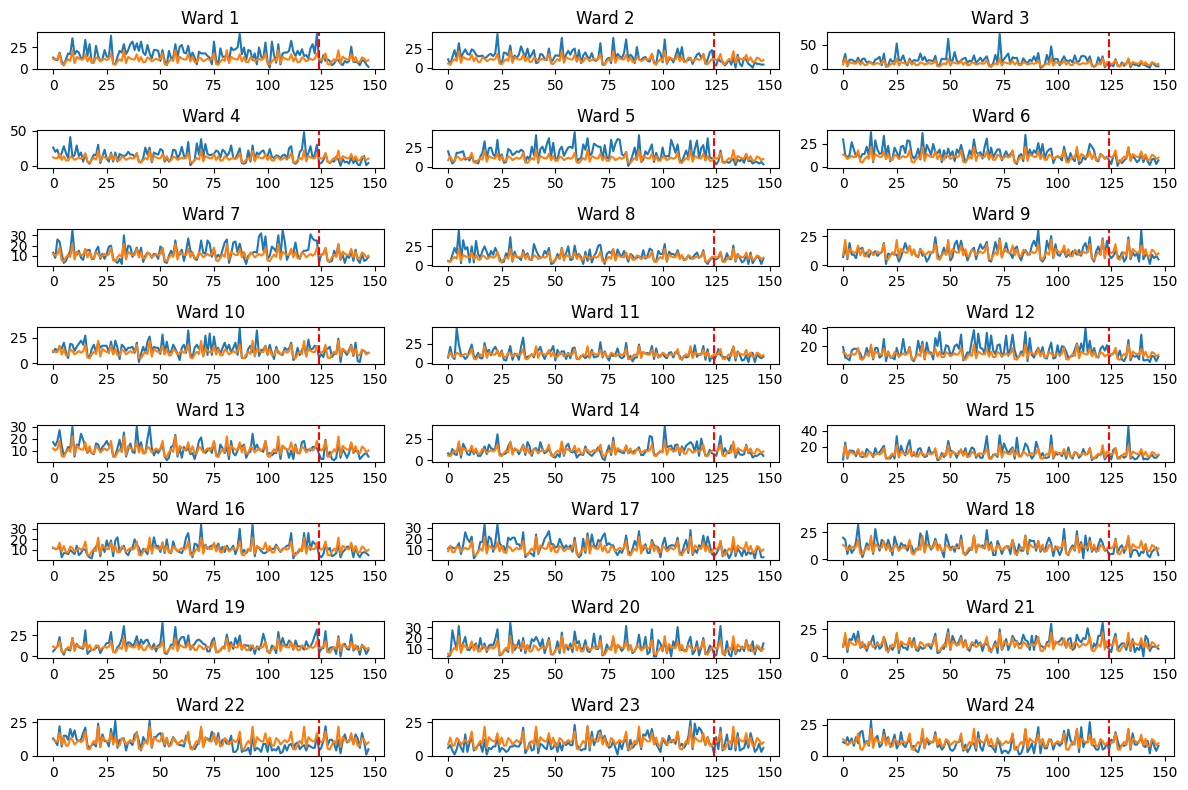

In [114]:
# Create a 4x6 grid of subplots
fig, axes = plt.subplots(8, 3, figsize=(12, 8))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Loop through each subplot and plot the data
for i, ax in enumerate(axes):
    ax.plot(actual_combined[i], label=f"Actual training values for ward {i}")
    ax.plot(tot_array[i], label=f"Actual training values for ward {i}")
    ax.axvline(x= actual_tr.shape[1], c='r', linestyle='--', label='train / test split')
    
    ax.set_title(f'Ward {i+1}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Evaluation

In [115]:
act_all = actual_combined
pred_all = tot_array

On the whole set

In [116]:
all_MSE = mean_squared_error(y_true = actual_combined, y_pred=pred_all)
all_MAE = mean_absolute_error(y_true = actual_combined, y_pred=pred_all)
all_R2 = r2_score(y_true = actual_combined, y_pred=pred_all)
print(f"{all_MSE=}\n{all_MAE=}\n{all_R2= }")

all_MSE=39.43659
all_MAE=4.587662
all_R2= -0.08488415293563317


On the test part

In [117]:
pred_test = predicted_test
act_test = actual_te
test_MSE = mean_squared_error(y_true=act_test, y_pred=pred_test)
test_MAE = mean_absolute_error(y_true=act_test, y_pred=pred_test)
test_R2 = r2_score(y_true=act_test, y_pred=pred_test)
print(f"{test_MSE=}\n{test_MAE=}\n{test_R2= }\n")

test_MSE=24.000229
test_MAE=3.9979687
test_R2= -1.3034992051501224



Per ward (to check for outliers):

In [118]:
eval_metrics = [mean_squared_error, mean_absolute_error, r2_score]
metric_picked = 0
print("\tall\t \t\t\t test")
for i in range(act_all.shape[0]):
    print(i,"\t", eval_metrics[metric_picked](y_true=act_all[i], y_pred=pred_all[i]),"\t\t",eval_metrics[metric_picked](y_true=act_test[i], y_pred=pred_test[i]))

	all	 			 test
0 	 81.92829 		 29.132202
1 	 51.877316 		 36.873493
2 	 104.82825 		 16.84913
3 	 64.57308 		 32.68494
4 	 98.02828 		 25.563278
5 	 42.87838 		 14.745868
6 	 40.067806 		 12.958053
7 	 36.887856 		 13.20519
8 	 19.251144 		 24.478045
9 	 31.252533 		 19.949064
10 	 29.863869 		 24.736671
11 	 57.901367 		 32.84775
12 	 20.929436 		 23.938179
13 	 23.66009 		 24.678947
14 	 28.17486 		 39.743374
15 	 20.483171 		 22.422739
16 	 30.088194 		 26.430456
17 	 21.97399 		 25.15995
18 	 34.082874 		 22.292486
19 	 27.706154 		 27.993902
20 	 19.282368 		 20.807306
21 	 18.972797 		 19.645102
22 	 20.79536 		 26.84047
23 	 20.990705 		 12.028893


# Prediction 2

In [119]:
with torch.no_grad():
    predicted_train_2 = model(X_tr.to(device)).to("cpu").numpy() # Predicted values for the first training months [months x wards]
    predicted_train_2 = mm.inverse_transform(predicted_train_2) # Inverse the minmax transformation done earlier
    predicted_test_2 = model(X_te.to(device)).to("cpu").numpy()
    predicted_test_2 = mm.inverse_transform(predicted_test_2)
    
    predicted_all_2 = np.concatenate((predicted_train_2, predicted_test_2), axis=0)

df_predict = pd.DataFrame(data=predicted_all_2, columns=[f"P-{i}" for i in range(24)])

actual_tr_2 = y_tr.to("cpu").numpy()
actual_tr_2 = mm.inverse_transform(actual_tr_2)

actual_te_2 = y_te.to("cpu").numpy()
actual_te_2 = mm.inverse_transform(actual_te_2)

actual_all_2 = np.concatenate((actual_tr_2, actual_te_2), axis=0)
df_actual = pd.DataFrame(data=actual_all_2, columns=[f"A-{i}" for i in range(24)])

np.array_equal(df_actual["A-0"].values, values_barnet_vale)



True

In [120]:
df_predict.head(7)

,P-0,P-1,P-2,P-3,P-4,P-5,P-6,P-7,P-8,P-9,...,P-14,P-15,P-16,P-17,P-18,P-19,P-20,P-21,P-22,P-23
0,11.775846,10.175389,11.623480,17.994209,5.453361,4.74261,8.459155,11.124998,8.948029,21.693747,...,10.748561,16.881517,8.449597,13.643641,7.594295,7.773689,13.272470,11.864557,8.517712,10.092762
1,11.775846,10.175389,11.623480,17.994209,5.453361,4.74261,8.459155,11.124998,8.948029,21.693747,...,10.748561,16.881517,8.449597,13.643641,7.594295,7.773689,13.272470,11.864557,8.517712,10.092762
2,11.775846,10.175390,11.623481,17.994211,5.453361,4.74261,8.459156,11.124999,8.948030,21.693748,...,10.748562,16.881519,8.449598,13.643642,7.594296,7.773690,13.272472,11.864559,8.517712,10.092763
3,11.775846,10.175389,11.623480,17.994209,5.453361,4.74261,8.459155,11.124999,8.948029,21.693747,...,10.748561,16.881519,8.449598,13.643641,7.594295,7.773690,13.272470,11.864559,8.517712,10.092763
4,11.775847,10.175390,11.623481,17.994211,5.453361,4.74261,8.459156,11.124999,8.948030,21.693748,...,10.748562,16.881519,8.449598,13.643642,7.594296,7.773690,13.272472,11.864559,8.517712,10.092763
5,11.775846,10.175389,11.623480,17.994209,5.453361,4.74261,8.459155,11.124999,8.948029,21.693747,...,10.748561,16.881519,8.449598,13.643641,7.594295,7.773690,13.272470,11.864559,8.517712,10.092763
6,11.775846,10.175389,11.623480,17.994209,5.453361,4.74261,8.459155,11.124999,8.948030,21.693747,...,10.748561,16.881519,8.449598,13.643641,7.594295,7.773690,13.272472,11.864559,8.517712,10.092763


In [121]:
df_actual.head(7)

,A-0,A-1,A-2,A-3,A-4,A-5,A-6,A-7,A-8,A-9,...,A-14,A-15,A-16,A-17,A-18,A-19,A-20,A-21,A-22,A-23
0,13.0,11.0,10.0,19.0,9.0,4.0,11.0,18.0,17.0,36.0,...,13.0,34.0,15.0,29.0,7.0,7.0,27.0,15.0,9.0,11.0
1,22.0,14.0,14.0,39.0,6.0,5.0,14.0,21.0,19.0,29.0,...,22.0,30.0,21.0,32.0,19.0,16.0,28.0,18.0,12.0,22.0
2,22.0,21.0,9.0,22.0,9.0,4.0,21.0,12.0,13.0,29.0,...,18.0,27.0,13.0,19.0,13.0,5.0,20.0,18.0,18.0,18.0
3,15.0,13.0,5.0,32.0,10.0,5.0,24.0,14.0,14.0,16.0,...,25.0,41.0,17.0,25.0,10.0,22.0,21.0,10.0,18.0,5.0
4,25.0,14.0,12.0,31.0,8.0,1.0,32.0,16.0,7.0,29.0,...,21.0,33.0,20.0,15.0,21.0,16.0,23.0,15.0,16.0,12.0
5,24.0,29.0,18.0,41.0,11.0,4.0,14.0,23.0,12.0,32.0,...,17.0,24.0,22.0,17.0,15.0,15.0,16.0,12.0,14.0,17.0
6,18.0,15.0,19.0,44.0,9.0,5.0,20.0,19.0,16.0,29.0,...,28.0,20.0,14.0,25.0,13.0,17.0,23.0,6.0,7.0,18.0


# Visualization 2


In [122]:
pick_ward:int = 0

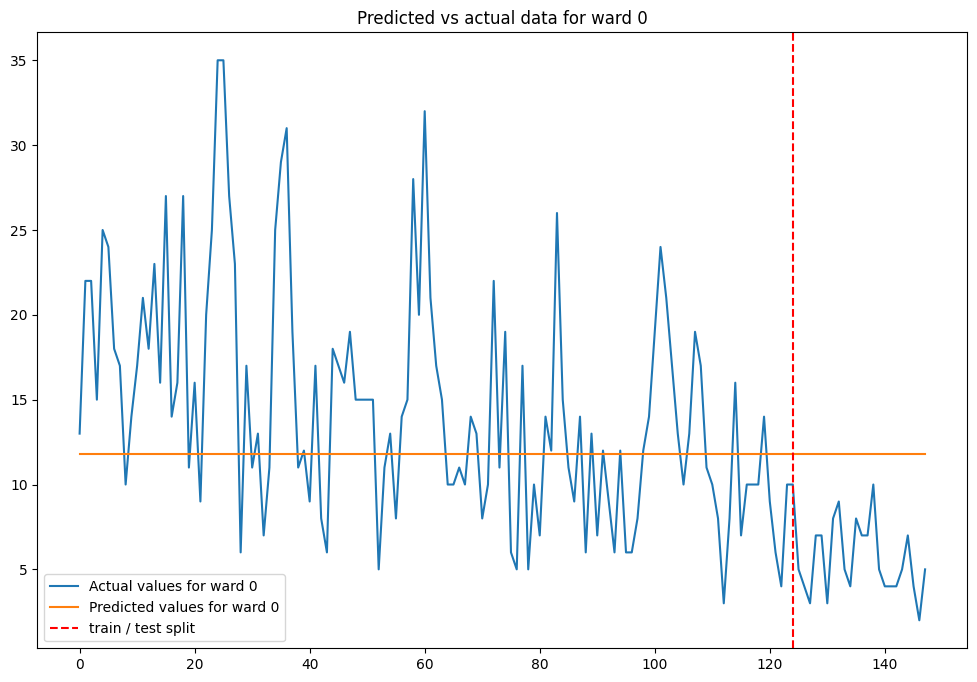

In [123]:
plt.figure(figsize=(12,8))
plt.plot(df_actual[f"A-{pick_ward}"].values, label=f"Actual values for ward {pick_ward}")
plt.plot(df_predict[f"P-{pick_ward}"].values, label=f"Predicted values for ward {pick_ward}")
plt.axvline(x=148-PREDICT_MONTHS, c='r', linestyle='--', label='train / test split')  #size of the training set
plt.title(f"Predicted vs actual data for ward {pick_ward}")
plt.legend()
plt.show()


In [124]:
all_MSE = mean_squared_error(y_true = actual_all_2 , y_pred=predicted_all_2)
all_MSE

39.436596

# Evaluation 2

In [125]:
def evaluate_model_general(predicted_all, predicted_test, predicted_train, actual_all, actual_test, actual_train) -> None:
    all_MAE = mean_absolute_error(y_true = actual_all , y_pred=predicted_all)
    all_MSE = mean_squared_error(y_true = actual_all , y_pred=predicted_all)
    all_R2 = r2_score(y_true = actual_all, y_pred=predicted_all)

    test_MAE = mean_absolute_error(y_true = actual_test , y_pred=predicted_test)
    test_MSE = mean_squared_error(y_true = actual_test , y_pred=predicted_test)
    test_R2 = r2_score(y_true = actual_test, y_pred=predicted_test)

    train_MAE = mean_absolute_error(y_true = actual_train , y_pred=predicted_train)
    train_MSE = mean_squared_error(y_true = actual_train , y_pred=predicted_train)
    train_R2 = r2_score(y_true = actual_train, y_pred=predicted_train)
    
    print(f"On all: {all_MAE= },\t {all_MSE= },\t {all_R2= } \n On test: {train_MAE= },\t {train_MSE= },\t {train_R2= } \n On test: {test_MAE= },\t {test_MSE= },\t {test_R2= } \n""")
    
    pass

In [126]:
evaluate_model_general(predicted_all =predicted_all_2, predicted_test = predicted_test_2, predicted_train = predicted_train_2, 
                        actual_all = actual_all_2, actual_test = actual_te_2, actual_train=actual_tr_2)

On all: all_MAE= 4.587662,	 all_MSE= 39.436596,	 all_R2= -0.10961687901516516 
 On test: train_MAE= 4.701796,	 train_MSE= 42.424282,	 train_R2= -0.2112509384296267 
 On test: test_MAE= 3.9979687,	 test_MSE= 24.000229,	 test_R2= -1.3034992051501224 

